In [9]:
import numpy as np
import pandas as pd

from collections import ChainMap
from pathlib     import Path

import seaborn as sns
import matplotlib.pyplot as plt

import calendar
import itertools

from datetime import datetime

In [155]:
def _get_time_from_session(session_file):
  session2time = {}
  
  with(open(session_file,'r')) as f:
    for line in f:
      atts = line.rstrip('\n').split(' ')
      
      session2time[int(atts[0])] = int(atts[2])
      
  return session2time

s2time = dict(ChainMap(*[ _get_time_from_session(session_file) for session_file in Path('../data').glob('*_sessions.dat') ]))

# Document life

We start by looking at the lifetime of each document, which is the time delta between the first and the last appearances of a document (i.e. the first and the last time it has been recommended).

In [156]:
docs = {}

# Looping over all click files of the dataset.
for i,click_file in enumerate(Path('../data').glob('*_clicks.dat')):
  _df = pd.read_csv(click_file,sep=' ',names=['session_id','item_id','rank','score','click_timestamp'])
  _df['session_time'] = _df.session_id.apply(lambda x: s2time[x])
  
  # Computing the total number of views (clicks) obtained by each document.
  doc_views = _df[_df.click_timestamp > 0]['item_id'].value_counts().to_dict()
  # Minimum and maximum timestamp for the current click file.
  _g = _df.groupby('item_id')['session_time'].agg(['min','max']).to_dict('index')
  
  recurrent_docs = (_g.keys() & docs.keys())
  for i in _g.keys():
    views = doc_views[i] if i in doc_views else 0
    # Computing maximum and minimum timestamp for documents occuring
    # in multiple click files.
    if i in recurrent_docs:
      docs[i]['min'] = np.min([_g[i]['min'],docs[i]['min']])
      docs[i]['max'] = np.max([_g[i]['max'],docs[i]['max']])
      docs[i]['views'] += views
    else:
      docs[i] = {'min': _g[i]['min'], 'max': _g[i]['max'], 'views': views}

docs_df = pd.DataFrame.from_dict(docs,orient='index')
docs_df['life_span'] = docs_df['max'] - docs_df['min']

In [21]:
print('{:.2f}% of documents have been recommended only once.'.format(100*len(docs_df[docs_df.life_span == 0])/len(docs_df)))
print('The maximum lifetime of a document in the dataset in {:.2f} hours.'.format(docs_df.life_span.max()/3600))
print('The mean lifetime of a document is {:.2f} hours, and the median is {:.2f} hours.'.format(np.mean(docs_df[docs_df.life_span > 0].life_span/3600),np.median(docs_df[docs_df.life_span > 0].life_span)/3600))

3.60% of documents have been recommended only once.
The maximum lifetime of a document in the dataset in 45.67 hours.
The mean lifetime of a document is 19.74 hours, and the median is 22.54 hours.


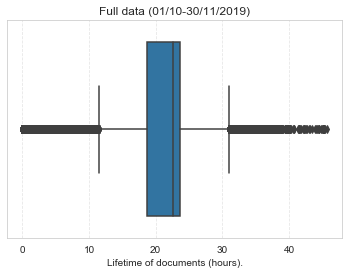

In [89]:
sns.set_style("whitegrid",{'grid.color': '.9','grid.linestyle': '--'})
ax = sns.boxplot(x=docs_df[docs_df.life_span > 0].life_span/3600)
g = ax.set(xlabel='Lifetime of documents (hours).',title='Full data (01/10-30/11/2019)')

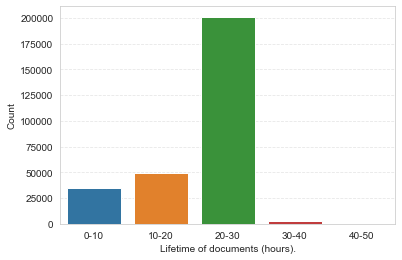

In [90]:
docs_df['binned_lifespan'] = pd.cut(docs_df[docs_df.life_span > 0].life_span/3600,[0,10,20,30,40,50],labels=['0-10','10-20','20-30','30-40','40-50'])
ax = sns.countplot(x='binned_lifespan',data=docs_df)
g = ax.set(xlabel='Lifetime of documents (hours).',ylabel='Count')

As shown on the above graphics, the lifetime of documents is quite small with an average and a median smaller than one day.
These findings emphasise the role that freshness plays in the recommendation ranking function: documents that are more than 1 day old are basically considered irrelevant for the ranking function.

This has major implications for the development of user embeddings that capture the latent preferences of the users.
Most methods rely on the observation of the same documents for multiple users, which would be problematic in our case if we consider data spanning multiple months.
Two users might be very similar in reality in the sense that they read or skip documents discussing the same topics and should then have very close user embeddings, but this similarity could not be captured due to the same document id only occurring over a small period of time.

We identified two possible solutions at this problem:
* simply avoid the problem for now and compute micro-batches of user embeddings based solely on their interactions within a single day
* use the text content of documents to compute topical similarity metrics between documents. Following a semi-supervised approach, we would then be able to compute the chances of positive (or negative) feedback for documents that are similar to the explicit feedback already recorded for each user.

For simplicity, we will start with the first approach before diving deeper.

# Document views

We quickly explore the potential relation between the absolute number of views (i.e. number of times the document has been clicked) and its lifetime.
The question we aim to answer is: Is the number of views of document a simple factor of its lifetime?

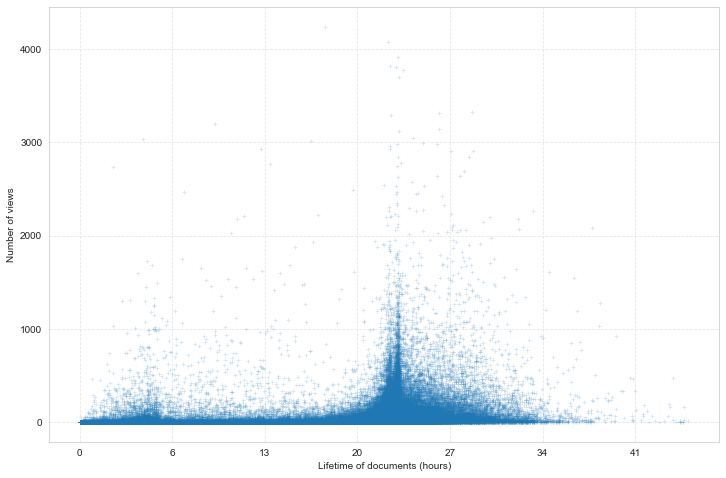

In [91]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="life_span", y="views", data=docs_df, s=12, marker='+', alpha=0.2)
xlabels = [int(x) for x in ax.get_xticks()/3600]
ax.set_xticklabels(xlabels)
g = ax.set(xlabel='Lifetime of documents (hours)',ylabel='Number of views')
#ax.set(ylim=(1, 10000),xlim=(1,300000))
#g = ax.set(yscale='log',xscale="log")

We see no general trend from the above graphics.
This suggests that users are not severely biased towards the freshness of documents, although one might argue that all documents with a lifetime < 48 hours are "fresh".

We can however observe two spikes of views: one small spike for "disposable" documents that span no more than 6 hours, and another larger one around 24 hours.
These spikes might require more investigation on why such documents get more views, but they look like artefacts from the ranking/indexing policy of the recommender system, where some documents might get removed from the index or heavily downranked when they reach these lifetimes.

# Levels of personalisation

In this section, we compare the ranked lists of documents and compute their overlap ratios in order to characterise the extent of personalisation on different parts of the ranked list (i.e. top-ranked documents versus the rest).

More specifically, we compute the mean similarity between all pairs of users taken from a selected sample.
The similarity between user is estimated through the mean Jaccard index between all pairs of ranked lists of documents of each user session:
\begin{equation}
\text{sim}(u,u') = \frac{1}{|S_u| + |S_u'|} \sum_{i \in S_u} \sum_{j \in S_u':j\neq i} \frac{|\mathcal{R}(i) \cap \mathcal{R}(j)|}{|\mathcal{R}(i) \cup \mathcal{R}(j)|}
\end{equation}
where $S_u$ is the set of sessions of user $u$, and $\mathcal{R}(i)$ is the set of ranked documents of session $i$.

In [ ]:
days = ['20191013','20191014']

rank_df = pd.concat([ pd.read_csv('../data/'+x+'_v2_clicks.dat',sep=' ',names=['session_id','item_id','rank','score','click_timestamp']) for x in days ])

In [151]:
def _get_user_from_session(session_file):
  session2user = {}
  
  with(open(session_file,'r')) as f:
    for line in f:
      atts = line.rstrip('\n').split(' ')
      
      session2user[int(atts[0])] = int(atts[1])
      
  return session2user

s2user = dict(ChainMap(*[ _get_user_from_session('../data/'+_d+'_v2_sessions.dat') for _d in days ]))
rank_df['user_id'] = rank_df.session_id.apply(lambda x: s2user[x])

In [152]:
user_sessions = rank_df.groupby('user_id')['session_id'].unique().to_dict()

In [153]:
def jaccard_index(s1,s2):
  intersect = len(s1.intersection(s2))
  union = len(s1.union(s2))
      
  return intersect/float(union) if union > 0 else 0
  

data = {}
data_top7 = {}
data_rem = {}
Ns = [2,5,10,15,20,30,50,75,100,150,200,300,500]

sample_users = np.random.choice(list(user_sessions.keys()),np.max(Ns))

# This dictionary serves as a buffer which contains the ranked documents of a single session.
# Since the combination will seek these ranked lists multiple times, it might speed up
# computation a bit.
_temp = {}

# Add more and more users into the combinations.
for n in Ns:
  jaccards = []
  jaccards_top7 = []
  jaccards_rem = []

  # Take each unique pair of users from our sample...
  for user_i,user_j in set(itertools.permutations(sample_users[0:n], 2)):
    # Then take each unique pair of sessions from these two users...
    for _session,_session2 in set(itertools.product(user_sessions[user_i],user_sessions[user_j])):
      if _session not in _temp:
        _temp[_session] = rank_df[rank_df.session_id == _session].item_id.values
      if _session2 not in _temp:
        _temp[_session2] = rank_df[rank_df.session_id == _session2].item_id.values
        
      _ranked1 = set(_temp[_session])
      _ranked2 = set(_temp[_session2])
      
      _ranked1_top7 = set(_temp[_session][0:7])
      _ranked2_top7 = set(_temp[_session2][0:7])
      
      _ranked1_rem  = set(_temp[_session][7:49])
      _ranked2_rem  = set(_temp[_session2][7:49])
      
      # ... and compute their jaccard index.
      jaccards.append(jaccard_index(_ranked1,_ranked2))
      jaccards_top7.append(jaccard_index(_ranked1_top7,_ranked2_top7))
      jaccards_rem.append(jaccard_index(_ranked1_rem,_ranked2_rem))
      
      
  num_samples = len(jaccards)
  data[n]      = {'mean' : np.mean(jaccards), 'std': np.std(jaccards), 'n': num_samples}
  data_top7[n] = {'mean' : np.mean(jaccards_top7), 'std': np.std(jaccards_top7), 'n': num_samples}
  data_rem[n]  = {'mean' : np.mean(jaccards_rem), 'std': np.std(jaccards_rem), 'n': num_samples}

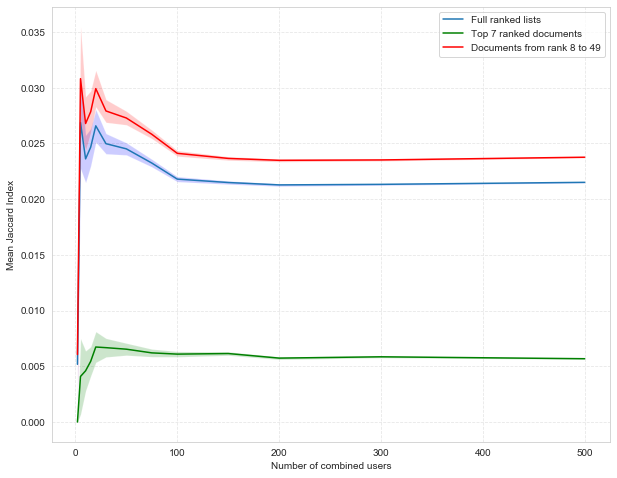

In [154]:
def _get_means(d):
  return np.array([ x['mean'] for l,x in d.items() ])

def _get_moes(d):
  # Computing the margin of error at 95% confidence https://en.wikipedia.org/wiki/Margin_of_error
  return np.array([ 1.959*x['std']/np.sqrt(x['n']) for l,x in d.items() ])

mean      = _get_means(data)
mean_top7 = _get_means(data_top7)
mean_rem  = _get_means(data_rem)

moe      = _get_moes(data)
moe_top7 = _get_moes(data_top7)
moe_rem  = _get_moes(data_rem)

sns.set_style("whitegrid",{'grid.color': '.9','grid.linestyle': '--'})

plt.figure(figsize=(10,8))
ax = sns.lineplot(x=Ns,y=mean,label='Full ranked lists')
ax = sns.lineplot(x=Ns,y=mean_top7,color='green',label='Top 7 ranked documents')
ax = sns.lineplot(x=Ns,y=mean_rem,color='red',label='Documents from rank 8 to 49')
ax.fill_between(Ns, mean+moe, mean-moe, facecolor='blue', alpha=0.2)
ax.fill_between(Ns, mean_top7+moe_top7, mean_top7-moe_top7, facecolor='green', alpha=0.2)
ax.fill_between(Ns, mean_rem+moe_rem, mean_rem-moe_rem, facecolor='red', alpha=0.2)

g = ax.set(xlabel='Number of combined users', ylabel='Mean Jaccard Index')

The above results show that there is a clear difference in the overlap of ranked lists whether we consider the full ranking or only the top 7 documents.
There is a huge variety of different documents in the top 7, leading to a lower Jaccard index than when considering the full ranked lists.
This observation is rather counterintuitive, as we would expect a higher Jaccard index for the top 7 documents that are supposed to be less personalised (and hence more likely to depend on other features that would lead to similar recommendations for different users), and a lower Jaccard index for the remaining of the ranked list that should be reflect the user preferences.

Since we make the complete opposite observation, we suppose that another factor plays a role in the diversity observed for the top 7 documents.
Could it be possible that the top-ranked, supposedly not personalised, documents would have a very short lifetime and hence less likely to pop in the recommendations of other users?

In [169]:
lifetime = []

for user in sample_users:
  for session in user_sessions[user]:
    lt = docs_df.loc[rank_df[rank_df.session_id == session].item_id].life_span.values
    lifetime.append(lt)

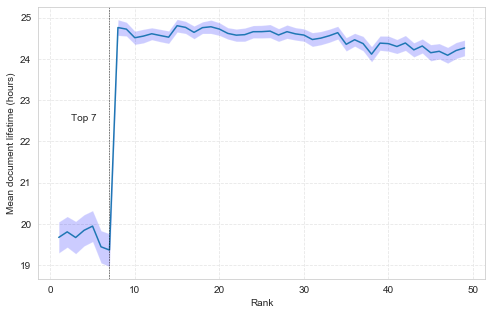

In [211]:
lifetime=np.asarray(lifetime)

mean_lt = np.mean(lifetime,axis=0)/3600
moe_lt  = [ 1.959*(np.std(lifetime[:,i])/3600)/np.sqrt(len(lifetime[:,i])) for i in range(49) ]

plt.figure(figsize=(8,5))
ax = sns.lineplot(x=list(range(1,50)),y=mean_lt)
ax.fill_between(list(range(1,50)), mean_lt+moe_lt, mean_lt-moe_lt, facecolor='blue', alpha=0.2)
plt.axvline(7,linewidth=.5,linestyle='--',color='black')
plt.text(2.5,22.5,'Top 7')
g = ax.set(xlabel='Rank',ylabel='Mean document lifetime (hours)')

Answering our previous question, this graphic shows a large disparity between the average lifetime of top 7 ranked documents and the remaining of the ranked lists.
Following our hypothesis, we believe that these top 7 ranked documents usually are "fresh" and promoted by the ranking function especially for this reason, which may account for the unexpected differences in Jaccard index.

# Quantifying position bias

We previously observed a strong bias towards documents with a lower lifetime for the top 7 ranked documents, which is a direct result from the ranking function.
We now explore whether users have a tendency to click more on top ranked documents, which would exhibit a form of position bias.

In [27]:
def format_df(click_file):
  _df = pd.read_csv(click_file,sep=' ',names=['session_id','item_id','rank','score','click_timestamp'])
  _df = _df[_df.click_timestamp > 0]
  _df['day'] = _df.click_timestamp.apply(lambda x: calendar.day_name[datetime.fromtimestamp(x).weekday()])
  
  return _df

# Looping over all click files of the dataset.
click_df = pd.concat([ format_df(click_file) for i,click_file in enumerate(Path('../data').glob('*_clicks.dat')) ])

In [34]:
counts_per_day = click_df.groupby(['rank','day']).size().to_frame('count').reset_index()

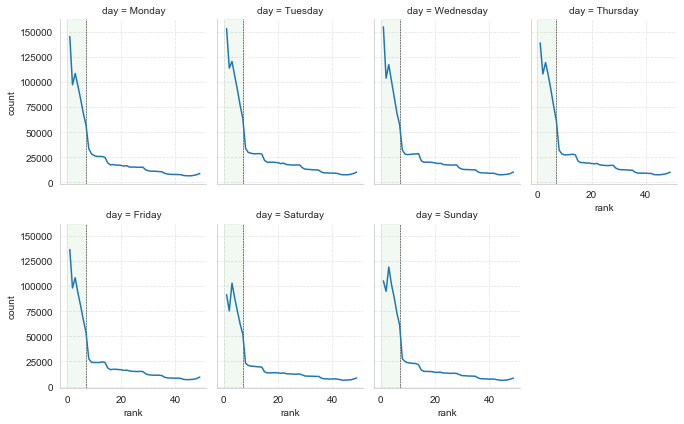

In [65]:
sns.set_style("whitegrid",{'grid.color': '.9','grid.linestyle': '--'})
g = sns.FacetGrid(counts_per_day, col="day", col_wrap=4, aspect=.8,col_order=list(calendar.day_name))
for ax in g.axes.flat:
  ax.axvline(7,linewidth=.5,linestyle='--',color='black')
  ax.axvspan(0, 7, alpha=0.05, color='green')
g.map(sns.lineplot, "rank", "count");

As expected, a strong position bias is present even within the top 7 ranked documents (represented by the green shade).
Interestingly, there seem to be some kind of bias towards the 3rd ranked documents, with their total number of clicks surpassing the 1rst ranked documents for Saturdays and Sundays.
Eye tracking studies (e.g. https://www.sciencedirect.com/science/article/pii/S0042698910004025) show that human vision tends to be biased the center of screens, which might explain such a